회귀 캐글 필사

# House Prices 주택 가격 예측하기

https://www.kaggle.com/code/subinium/subinium-tutorial-house-prices-advanced

## 라이브러리, 데이터 확인하기

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings. filterwarnings('ignore') # warnings 무시
%matplotlib inline

# sns theme
sns.set_style('darkgrid')

# 소수점 표현 제한
pd.set_option('display.float_format', lambda x : '{:.3f}'. format(x))

# 디렉토리 내, 사용가능 파일 체크
import os
current_directory = os.getcwd()
file_list = os.listdir(current_directory)
print(file_list)

['.config', 'drive', 'sample_data']


In [45]:
# 데이터 읽기
train_df = pd.read_csv("/content/drive/MyDrive/2024-2 ESAA/Data/DATA/House_train.csv")
test_df = pd.read_csv('/content/drive/MyDrive/2024-2 ESAA/Data/DATA/House_test.csv')

In [46]:
# 데이터 체크
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


-> 가격 특성을 제외하면 80개의 특성

-> 그 외에는 데이터 분석과 상관 없는 ID 특성도 있음

In [47]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# drop the 'Id' column since it's unnecessary for the prediction process
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

## Data Processing
### Outliers 처리
공식 문서에서 이상치가 있다고 언급함 -> 이상치를 찾고 해결하기

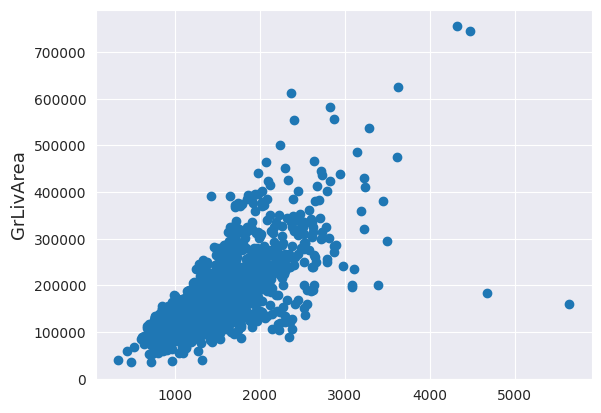

In [48]:
# 이상치 확인을 위해 그래프 그리기

fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.ylabel('GrLivArea', fontsize=13)
plt.show()

-> 낮은 SalePrice에서 이상한 2개의 데이터 확인됨 -> 삭제하기

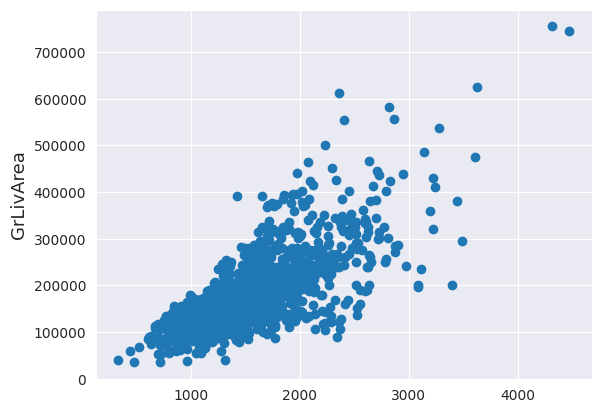

In [49]:
# Deleting outlier
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

# Check the Graph again
fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.ylabel('GrLivArea', fontsize=13)
plt.show()

- 이상치 제거는 훈련에 있어 매우 좋은 방법

- 그러나 전부 다 제거하지 않음
 - 훈련 데이터에 이상치가 많을 수 있지만, 테스트 데이터에도 이상치가 존재할 수 있음
  - 모든 이상치를 제거하면 모델에 더 안 좋은 영향을 미침

### Target Variable : SalePrice
- Q-Q plot

180932.91906721535 79467.78892987774


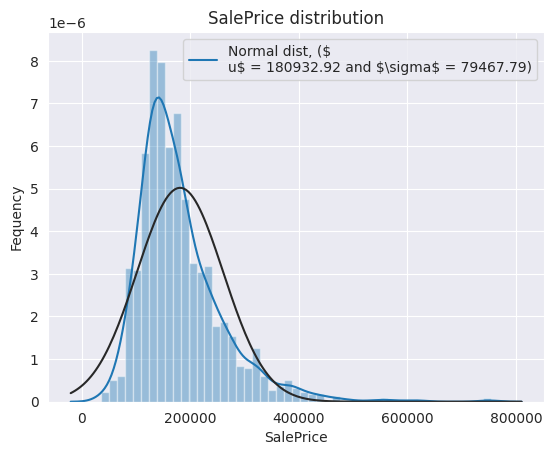

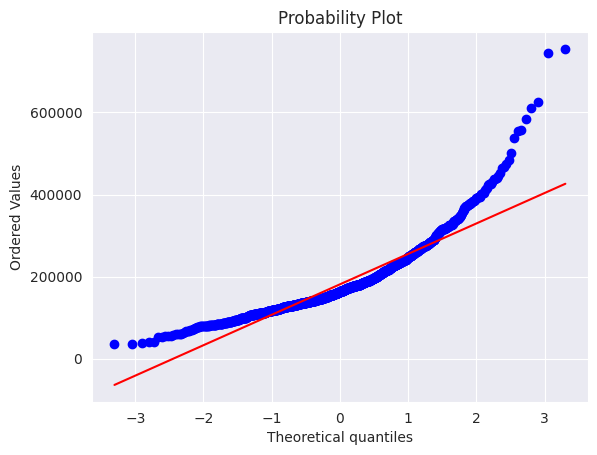

In [50]:
sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 그래프를 그려 분포를 확인하기
plt.legend(['Normal dist, ($\nu$ = {:.2f} and $\sigma$ = {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Fequency')
plt.title('SalePrice distribution')

# Q-Q plt
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

-> 오른쪽으로 치우쳐진 분포

데이터 정규화를 위해 Log-transform 진행

12.024015155682552 0.3995757283645756


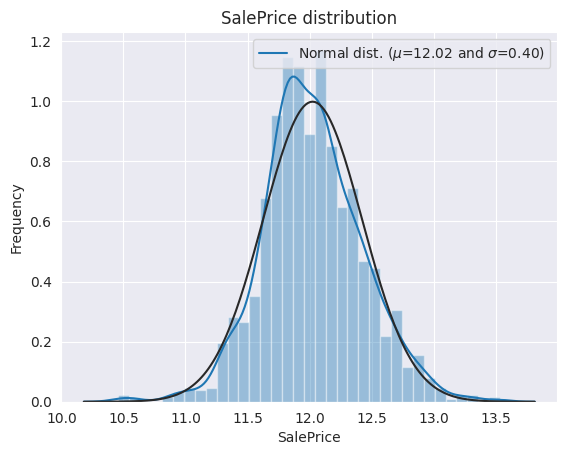

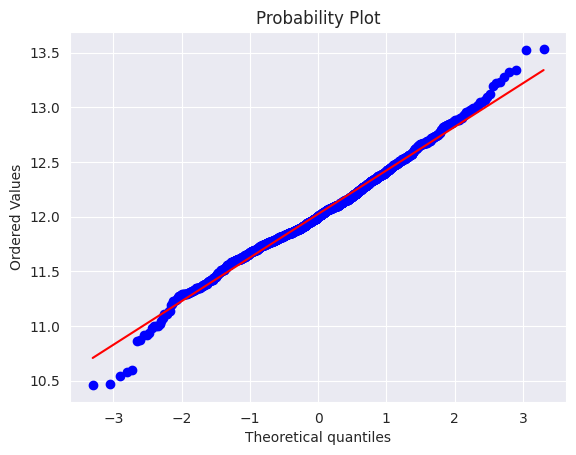

In [51]:
# log1p

train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 똑같이 분포를 확인하기
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

-> 정규분포에 근접하게 바뀜

## Feature Engineering
데이터를 하나로 묶어서 사용

In [52]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing Data 확인하기

In [53]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

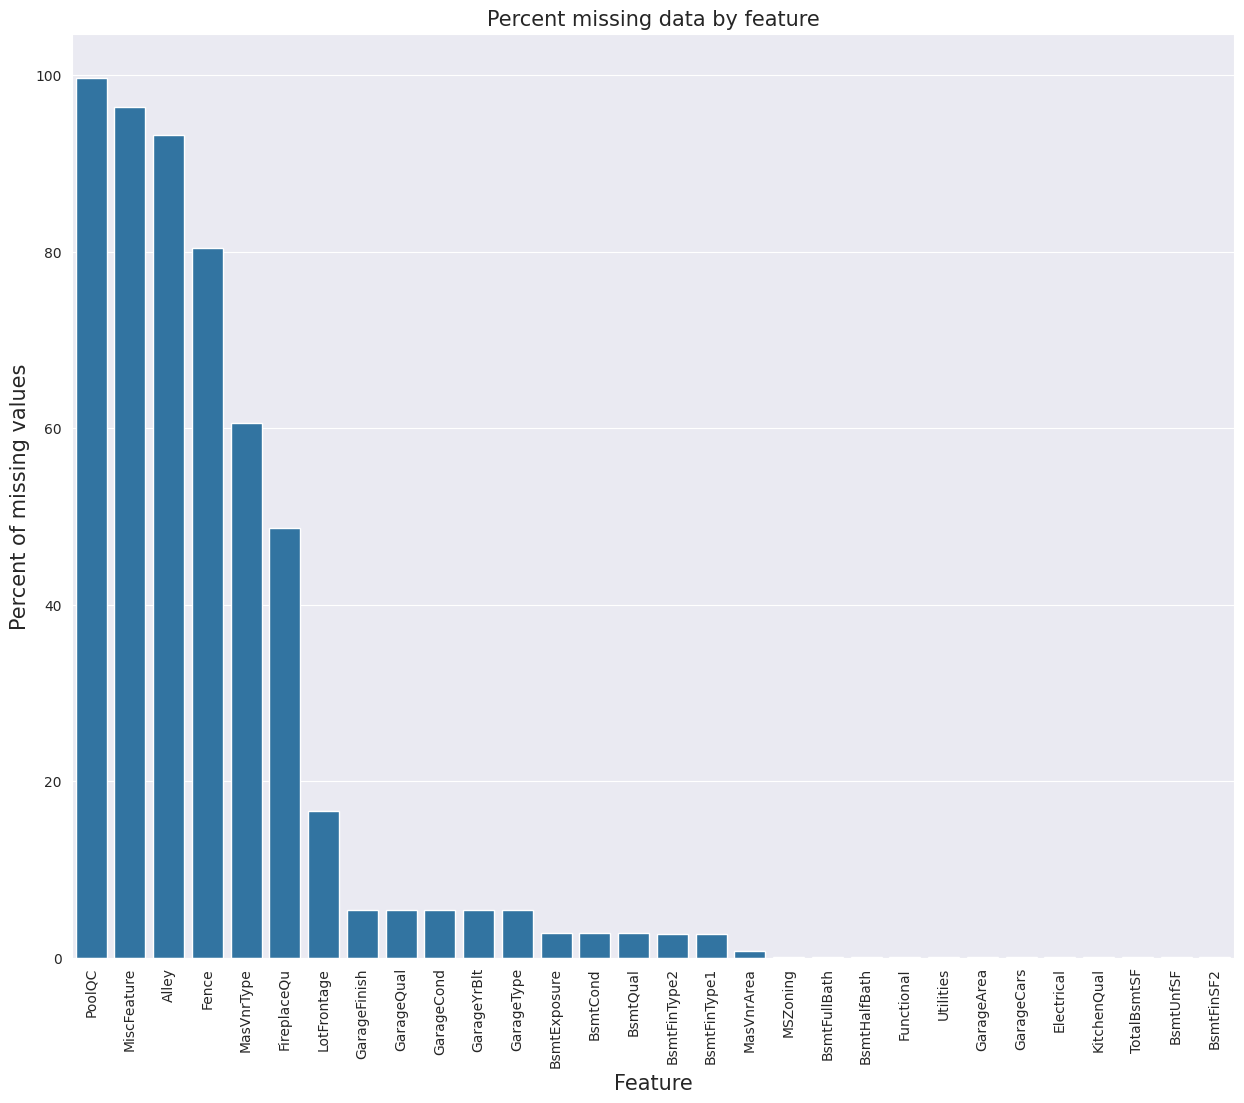

In [54]:
# Missing Data 시각화

f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### Data Correlation
SalePrice와 다른 요소간의 상관관계 확인하기

<Axes: >

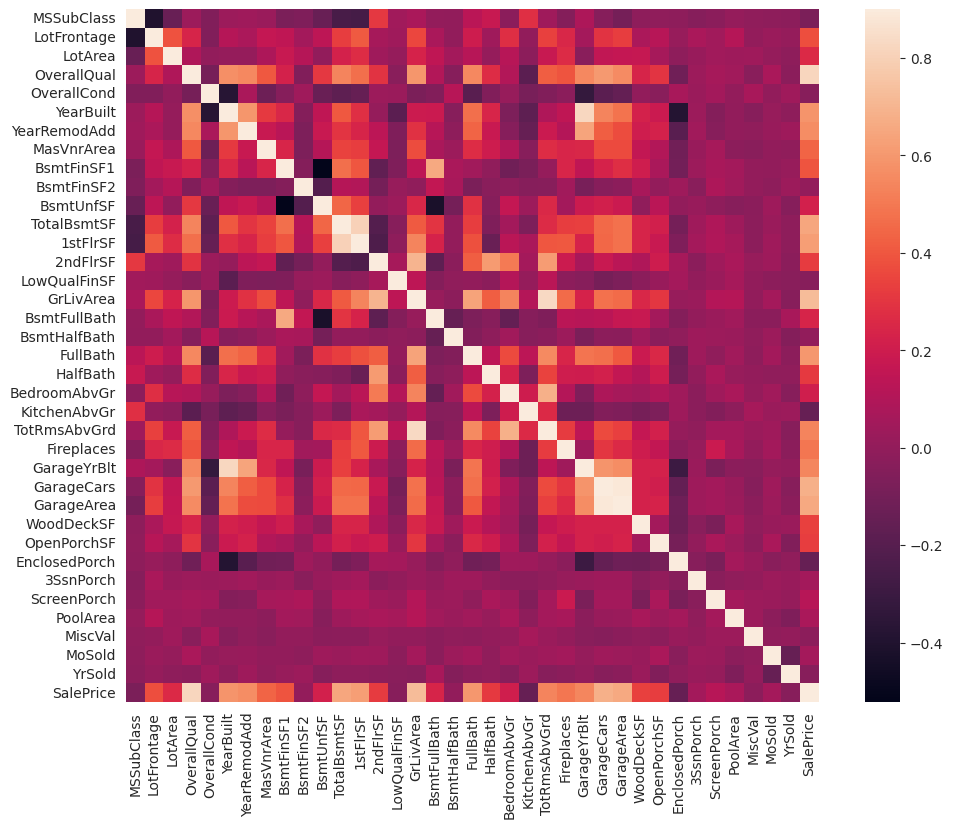

In [55]:
corrmat = train_df.select_dtypes(include=['float64', 'int64']).corr() # 숫자열만 선
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Inputing Missing Values
누락된 값을 채워넣기

- PoolQC : NA 값은 'No Pool' 을 의미 -> 99% 값으로 채우기

In [56]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- MIscFeature, Alley, Fence, FireplaceQu : NA 값은 'no misc feature' 의미

In [57]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage : 거리와 집의 거리 요소로 이웃들의 거리와 유사한 값을 가짐 -> 중앙값으로 채우기

In [58]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x : x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual, GarageCond : None 으로 처리

In [59]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- 빈 데이터들을 'None' 또는 0으로 처리

In [60]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning (The general zoning classification) : RL이 최빈값 -> RL로 채우기

In [61]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
# mode 메서드 이용 -> 최빈값 자동 선택

- Utilities : 모든 값이 'Allpub', 한 개만 'NoSeWa', 두 개가 NA 값 -> 예측에 도움이 안 되므로 drop 하기

In [62]:
all_data = all_data.drop(['Utilities'], axis=1)

- Functional : NA 값은 'typical'을 의미 -> 'Typ' 로 채우기

In [63]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType : 최빈값으로 채우기

In [64]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

남은 Missing Data 가 있는지 확인

In [65]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### More features engineering
- 수치형 값들 중 범주형인 특성을 변환하기

In [66]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

- 범주형 데이터를 label encoding으로 변환

In [67]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


### Adding one more important feature
집의 가용 평수 특성 추가하기 : basement + 1층 + 2층 공간ㅡ

In [68]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Skewed feature

In [69]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


- 데이터를 정규화하기
 - Box Cox Transformation of (highly) skewed features : 정규 분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법 중 하나입니다.

In [70]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


### Getting Dummy categorical features
- 범주형 데이터를 get_dummies 이용하여 변환

In [71]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


- 다시 train_df와 test_df로 나누기

In [72]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

## Modeling

### import libraries

In [73]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Define a cross validation strategy
- cross_val_score 함수 이용하기
- K-fold 사용하여 검증의 정확도 높이기

In [74]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

### Base Models
- LASSO Regression
 - 이상치에 매우 민감
 - 이상치를 더 규제하기 위해 pipeline에 RobustScaler() 메서드를 이용
- Elastic Net Regression
 - 이상치에 매우 민감
 - 이상치를 더 규제하기 위해 pipeline에 RobustScaler() 메서드를 이용

In [75]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- Kernel Ridge Regression

In [76]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- Gradient Boosting Regression
 - huber 손실 함수로 이상치를 관리
 - 다른 손실함수에 비해 이상치에 대해 민감하지 않음

In [77]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

- XGBoost
 - 하이퍼 파라미터 설정은 bayesian optimization 사용함


In [78]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- LightGBM

In [79]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

- Base Models Scores
 - 교차 검증을 통해 score 구하기

In [80]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)

ElasticNet score: 0.1116 (0.0074)

Kernel Ridge score: 0.1153 (0.0075)

Gradient Boosting score: 0.1167 (0.0083)

Xgboost score: 0.1167 (0.0068)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 wil

### Stacking Models

- Simplest Stacking approach : Averaging base models
 - 모델들의 성능을 평균하여 사용하기

In [81]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

     #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

### Averaged Base Models Score
- ENet, GBoost, KRR, LASSO 를 이용해 score 계산

In [82]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1087 (0.0077)



### Less simple Stacking : Adding a Meta-model
- meta model 추가함
- base model들의 평균과 이 out-of-foldsd 예측을 이용해 meta-model 훈련하기

 - 1. 훈련 데이터를 분리된 데이터셋 train, holdout으로 나누기
 - 2. trian 데이터로 훈련하기
 - 3. holdout 데이터로 테스트하기
 - 4. 3 을 통해 예측값 구하기
 - 5. meta model를 통해 예측 값으로 모델을 학습하기

- [예시 : 5-fold stacking 적용하기]
- 훈련 데이터를 5개로 나누기
- 총 5번의 반복문 진행
  - 각 반복문은 4folds로 훈련 진행
  - 나머지 1 fold를 예측
- out-of-folds 예측값을 가짐
- meta model을 통해 예측값으로 모델 학습하기
  - 테스트 데이터에서 모든 모델의 예측값의 평균 구하기
  - 평균값을 meta-features로 사용하여 meta-model의 마지막 예측값 만들기

- 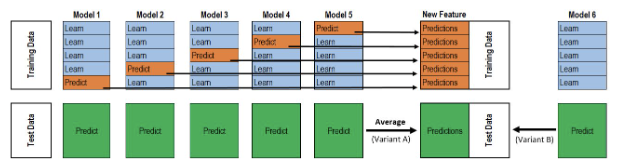

### Stacking averaged Models Class
- pseudo 코드 구현
- 베이스 모델의 예측값을 하나의 특성으로 사용하여 최종 분류를 만드는 것


- 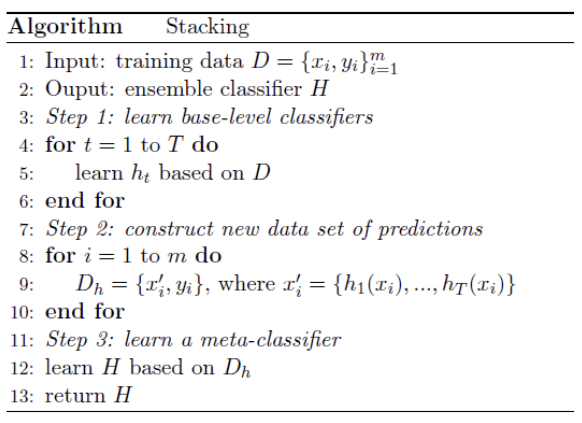


In [83]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

 # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

         # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

### Stacking Averaged models Score
- score로 성능 비교하기

In [84]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=(lasso)
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


-> meta learner을 이용하여 더 나은 점수를 받을 수 있음

### Ensembling StackedRegressor, XGBoost and LightGBM
- XGBoost와 LightGBM을 이용해 최종 결과 만들기


- rmsle 함수 정의

In [85]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

- expm1 함수 : 정규화에 이용하기 위한 log1p 함수의 역함수

- StackedRegressor

In [86]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096665937


- XGBoost

In [87]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.0866951518038854


- LightGBM

In [88]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

In [89]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07653967781115523


- Ensemble prediction

In [90]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

- Submission

In [91]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv', index=False)